### import modules

In [1]:
from array import array
from types import MappingProxyType

from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.datasets import fetch_california_housing
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import kennard_stone as ks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes
from tqdm.auto import trange
import seaborn as sns

### Constants & Variables
Set random_state for reproducibility.

In [2]:
SEED = 334
rng = np.random.RandomState(SEED)
rf = RandomForestRegressor(n_estimators=100, random_state=rng)

### Sample data

The dataset of California house prices is too large and takes a long time to run, so we extracted as much data as that of Boston.

In [3]:
n_data = 506  # same as boston

X: pd.DataFrame
y: pd.Series
X, y = fetch_california_housing(as_frame=True, return_X_y=True)
X = X.iloc[:n_data]
y = y.iloc[:n_data]
display(X.head(), y.to_frame().head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


,MedHouseVal
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422


## train_test_split

### scikit-learn
The randomness is so strong that I tried it 1000 times.

In [4]:
N_ITER = 1000

In [5]:
scores = MappingProxyType(
    {
        "MSE": array("f"),
        "R2": array("f"),
    }
)
for _ in trange(N_ITER):
    X_train, X_test, y_train, y_test = ms.train_test_split(
        X, y, test_size=0.2, random_state=rng
    )
    rf.fit(X_train, y_train)
    y_pred_on_test = rf.predict(X_test)
    scores["MSE"].append(mse(y_test, y_pred_on_test))
    scores["R2"].append(r2_score(y_test, y_pred_on_test))

  0%|          | 0/1000 [00:00<?, ?it/s]

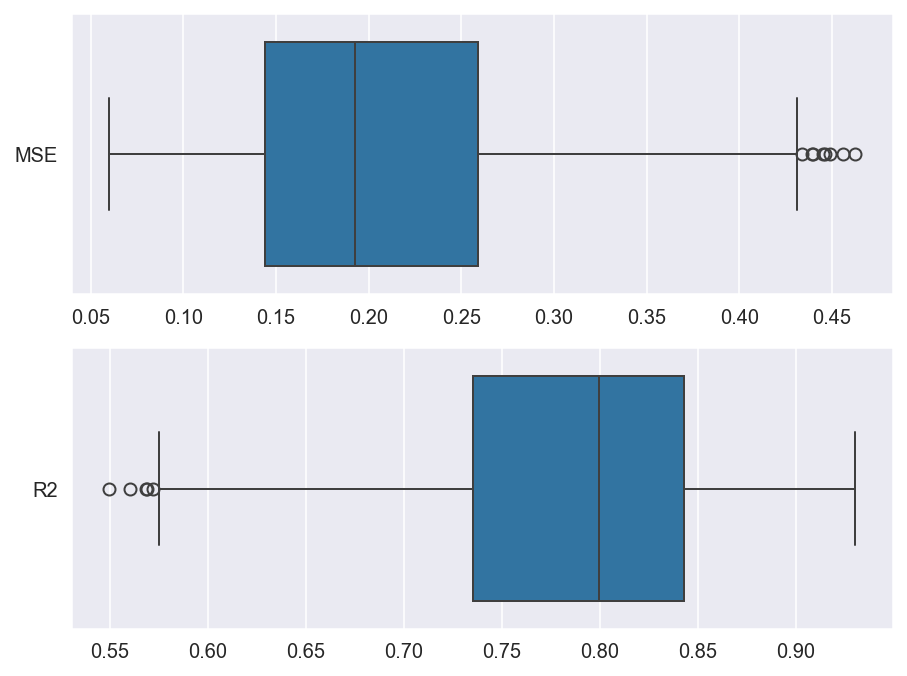

In [6]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(
    ncols=1, nrows=len(scores), facecolor="w", figsize=(6.4, 4.8), dpi=144
)
for idx_score, score_name in enumerate(scores):
    ax: matplotlib.axes.Axes = axes[idx_score]
    sns.boxplot(
        data=pd.DataFrame(scores[score_name], columns=[score_name]),
        orient="h",
        ax=ax,
    )
fig.tight_layout()

In [7]:
sns.reset_defaults()

#### Average

In [8]:
for score_name, v in scores.items():
    print("{0}: {1:.3f}".format(score_name, np.average(v).item()))

MSE: 0.206
R2: 0.786


### Kennard Stone

In [9]:
X_train, X_test, y_train, y_test = ks.train_test_split(X, y, test_size=0.2)

2024-11-18 22:04:45,465 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2024-11-18 22:04:45,470 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



In [10]:
rf = clone(rf)
rf.fit(X_train, y_train)
y_pred_on_test = rf.predict(X_test)

In [11]:
print("MSE: {:.3f}".format(mse(y_test, y_pred_on_test)))
print("R2: {:.3f}".format(r2_score(y_test, y_pred_on_test)))

MSE: 0.067
R2: 0.910


## cross_val_score

In [12]:
N_SPLITS = 5

In [13]:
rf = clone(rf)

### scikit-learn

In [14]:
scores = MappingProxyType({"MSE": array("f"), "R2": array("f")})
for i in trange(N_ITER):
    kf = ms.KFold(n_splits=N_SPLITS, random_state=rng, shuffle=True)
    y_oof = ms.cross_val_predict(rf, X, y, cv=kf, n_jobs=-1)
    scores["MSE"].append(mse(y, y_oof))
    scores["R2"].append(r2_score(y, y_oof))

  0%|          | 0/1000 [00:00<?, ?it/s]

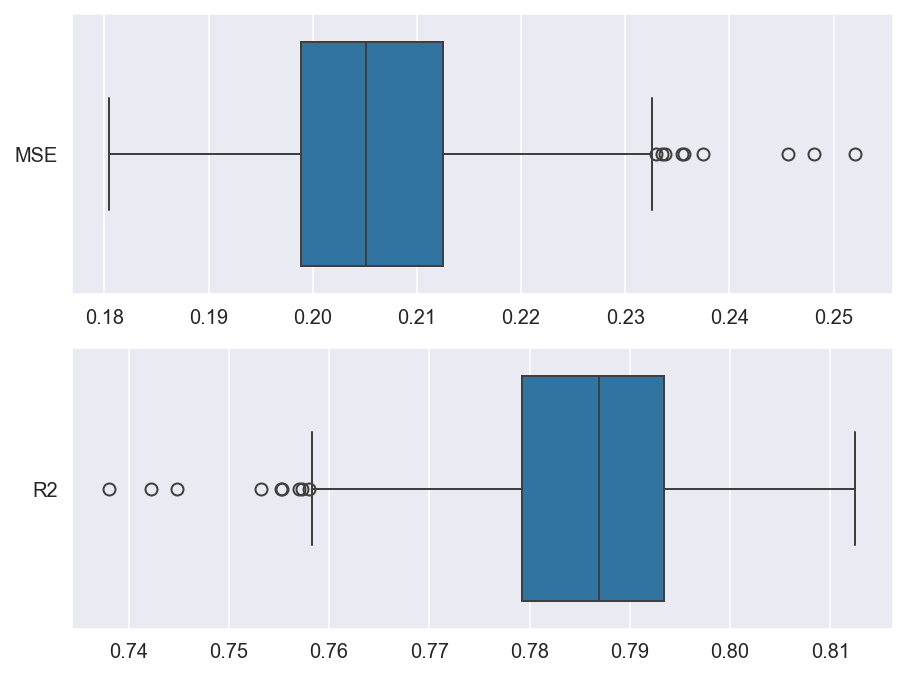

In [15]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(
    ncols=1, nrows=len(scores), facecolor="white", figsize=(6.4, 4.8), dpi=144
)
for idx_score, score_name in enumerate(scores):
    ax: matplotlib.axes.Axes = axes[idx_score]
    sns.boxplot(
        data=pd.DataFrame(scores[score_name], columns=[score_name]),
        orient="h",
        ax=ax,
    )
fig.tight_layout()

In [16]:
sns.reset_defaults()

In [17]:
for score_name, v in scores.items():
    print("{0}: {1:.3f}".format(score_name, np.average(v).item()))

MSE: 0.206
R2: 0.786


### Kennard Stone

In [18]:
kf = ks.KFold(n_splits=N_SPLITS)
y_oof = ms.cross_val_predict(rf, X, y, cv=kf, n_jobs=-1)
print("MSE: {:.3f}".format(mse(y, y_oof)))
print("R2: {:.3f}".format(r2_score(y, y_oof)))

2024-11-18 22:13:07,584 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2024-11-18 22:13:07,587 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



MSE: 0.199
R2: 0.793
